In [1]:
from __future__ import division, print_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import george
from george import kernels

import pandas as pd

from astropy.stats import median_absolute_deviation as MAD

In [68]:
fn = '../data/215900519P-ep20160806.csv'
df = pd.read_csv(fn, skiprows=39)
df['time'] = df.t - df.t[0]
df['flux'] = df.fdt_t_roll_2D/ np.median(df.fdt_t_roll_2D) - 1.0
df['ferr'] = np.ones_like(df.t) * MAD(df.flux) /10

print(np.shape(df.time), np.shape(df.flux), np.shape(df.ferr))

(3475,) (3475,) (3475,)


(-0.03, 0.03)

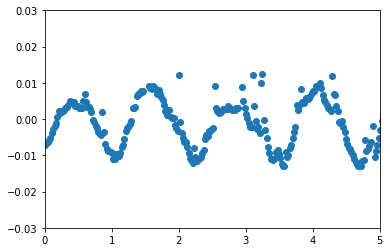

In [69]:
plt.scatter(df.time,df.flux)
plt.xlim(0,5)
plt.ylim(-0.03,0.03)

In [193]:
y = df.loc[(df.time < 15) * (np.abs(df.flux)<0.02),'flux']
yerr = df.loc[(df.time < 15) * (np.abs(df.flux)<0.02),'ferr']
t = df.loc[(df.time < 15) * (np.abs(df.flux)<0.02),'time']


print(np.shape(t)), print(np.shape(yerr)), print(np.shape(t))



(716,)
(716,)
(716,)


/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(None, None, None)

In [194]:
A = 0.001
l = 10.
G = 10.0
sigma = 0.001
P = 2.0
# kernel= A * kernels.ExpSquaredKernel(l) * kernels.ExpSine2Kernel(G, P) + kernels.WhiteKernel(sigma)   
kernel= A * kernels.ExpSquaredKernel(l) * kernels.ExpSine2Kernel(G, P) + kernels.WhiteKernel(sigma)   
                  

In [195]:

gp = george.GP(kernel,) #solver=george.HODLRSolver)
gp.compute(t, )
print(gp.lnlikelihood(y))
print(gp.grad_lnlikelihood(y))


1739.61643575
[ -22.68488475    6.17347078  -17.11000134   97.0518939  -320.95274159]


In [196]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.kernel.vector
results = op.minimize(nll, p0, jac=grad_nll)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(y))

1739.61643575
3284.01713594


In [197]:
print(results)

      fun: -3284.0171359382434
 hess_inv: array([[  1.46554730e-02,   4.63813730e-03,  -2.34828233e-03,
         -1.03995864e-05,  -3.00096306e-04],
       [  4.63813730e-03,   1.05614272e-02,   3.79311412e-04,
          7.59240512e-06,   6.02574402e-04],
       [ -2.34828233e-03,   3.79311412e-04,   1.05499060e-02,
         -1.42566800e-05,  -3.81134416e-03],
       [ -1.03995864e-05,   7.59240512e-06,  -1.42566800e-05,
          4.56936406e-06,   1.71775331e-05],
       [ -3.00096306e-04,   6.02574402e-04,  -3.81134416e-03,
          1.71775331e-05,   6.09918367e-03]])
      jac: array([ -1.33270750e-08,  -4.10261196e-08,   6.37410005e-07,
         5.26262378e-06,   1.45932538e-08])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 37
     njev: 63
   status: 0
  success: True
        x: array([-10.32022861,   1.68722506,   4.3669405 ,   0.8625197 , -12.99576048])


In [207]:
x = np.linspace(0, 15, 500)
mu, cov = gp.predict(y, x)
std = np.sqrt(np.diag(cov))

/Users/tom/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


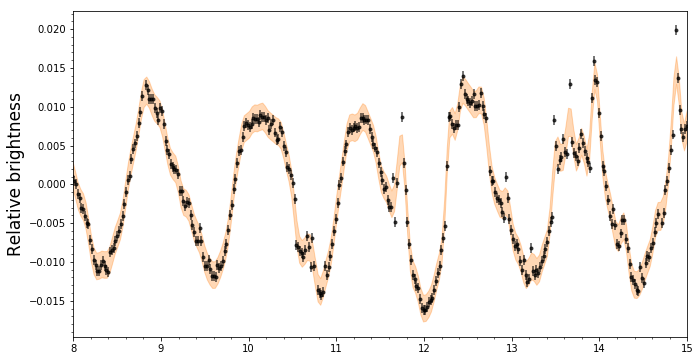

In [209]:
fig, ax = plt.subplots(1,1,figsize=[11,6], )

ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0,alpha=0.7)
ax.fill_between(x,mu-std,mu+std, color="#ff7f0e", alpha=0.3,
                edgecolor="none")
ax.set_xlim(8,15)

ax.set_ylabel('Relative brightness', fontsize=17)
ax.minorticks_on()